# 2022-03-16 Beyond Linear Models

## Last time

* Discussion
* Bias-variance tradeoff
* Linear models

## Today
* Assumptions of linear models
* Look at your data!
* Partial derivatives
* Loss functions

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

# Bias-variance tradeoff

The expected error in our approximation $\hat f(x)$ of noisy data $y = f(x) + \epsilon$ (with $\epsilon \sim \mathcal N(0, \sigma)$), can be decomposed as
$$ E[(\hat f(x) - y)^2] = \sigma^2 + \big(\underbrace{E[\hat f(x)] - f(x)}_{\text{Bias}}\big)^2 + \underbrace{E[\hat f(x)^2] - E[\hat f(x)]^2}_{\text{Variance}} . $$
The $\sigma^2$ term is irreducible error (purely due to observation noise), but bias and variance can be controlled by model selection.
More complex models are more capable of expressing the underlying function $f(x)$, thus are capable of reducing bias.  However, they are also more affected by noise, thereby increasing variance.

# Stacking many realizations

size(Y) = (500, 50)


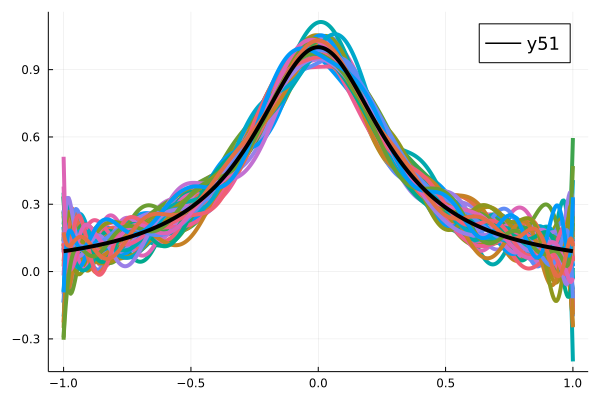

In [2]:
degree = 20
x = LinRange(-1, 1, 500)
Y = []
for i in 1:50
    yi = runge_noisy(x, 0.25)
    push!(Y, chebyshev_regress_eval(x, x, degree) * yi)
end

Y = hcat(Y...)
@show size(Y) # (number of points in each fit, number of fits)
plot(x, Y, label=nothing);
plot!(x, runge.(x), color=:black)

# Interpretation

* Re-run the cell above for different values of `degree`.  (Set it back to a number around 7 to 10 before moving on.)
* Low-degree polynomials are not rich enough to capture the peak of the function.
* As we increase degree, we are able to resolve the peak better, but see more eratic behavior near the ends of the interval.  This erratic behavior is **overfitting**, which we'll quantify as *variance*.
* This tradeoff is fundamental: richer function spaces are more capable of approximating the functions we want, but they are more easily distracted by noise.

# Mean and variance over the realizations

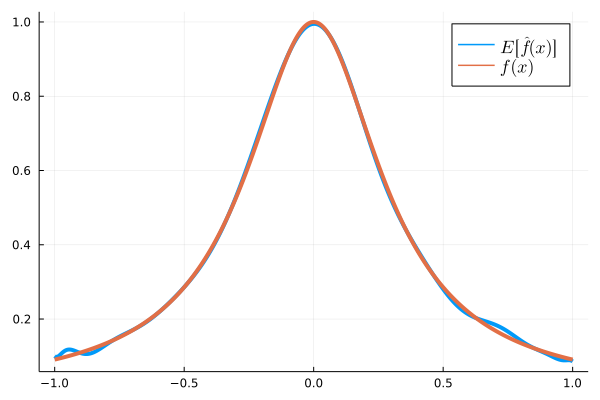

In [3]:
Ymean = sum(Y, dims=2) / size(Y, 2)
plot(x, Ymean, label="\$ E[\\hat{f}(x)] \$")
plot!(x, runge.(x), label="\$ f(x) \$")

size(Yvar) = (500, 1)


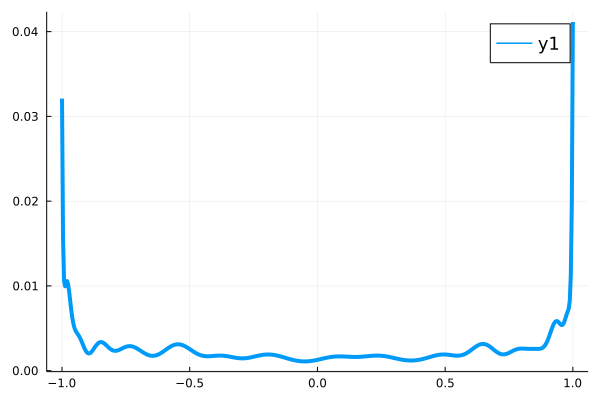

In [5]:
function variance(Y)
    """Compute the Variance as defined at the top of this activity"""
    n = size(Y, 2)
    sum(Y.^2, dims=2)/n - (sum(Y, dims=2) / n) .^2
end

Yvar = variance(Y)
@show size(Yvar)
plot(x, Yvar)

# Why do we call it a linear model?

We are currently working with algorithms that express the regression as a linear function of the model parameters.  That is, we search for coefficients $c = [c_1, c_2, \dotsc]^T$ such that

$$ V(x) c \approx y $$

where the left hand side is linear in $c$.  In different notation, we are searching for a predictive model

$$ f(x_i, c) \approx y_i \text{ for all $(x_i, y_i)$} $$

that is linear in $c$.

# Standard assumptions for regression
## (the way we've been doing it so far)

1. The independent variables $x$ are error-free
1. The prediction (or "response") $f(x,c)$ is linear in $c$
1. The noise in the measurements $y$ is independent (uncorrelated)
1. The noise in the measurements $y$ has constant variance

There are reasons why all of these assumptions may be undesirable in practice, thus leading to more complicated methods.


# [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

![](https://seaborn.pydata.org/_images/anscombes_quartet.png)

# Loss functions

The error in a single prediction $f(x_i,c)$ of an observation $(x_i, y_i)$ is often measured as
$$ \frac 1 2 \big( f(x_i, c) - y_i \big)^2, $$
which turns out to have a statistical interpretation when the noise is normally distributed.
It is natural to define the error over the entire data set as
\begin{align} L(c; x, y) &= \sum_i \frac 1 2 \big( f(x_i, c) - y_i \big)^2 \\
&= \frac 1 2 \lVert f(x, c) - y \rVert^2
\end{align}
where I've used the notation $f(x,c)$ to mean the vector resulting from gathering all of the outputs $f(x_i, c)$.
The function $L$ is called the "loss function" and is the key to relaxing the above assumptions.

# Gradient of scalar-valued function

Let's step back from optimization and consider how to differentiate a function of several variables.  Let $f(\boldsymbol x)$ be a function of a vector $\boldsymbol x$.  For example,

$$ f(\boldsymbol x) = x_1^2 + \sin(x_2) e^{3x_3} . $$

We can evaluate the **partial derivative** by differentiating with respect to each component $x_i$ separately (holding the others constant), and collect the result in a vector,

\begin{align}
\frac{\partial f}{\partial \boldsymbol x} &= \begin{bmatrix} \frac{\partial f}{\partial x_1} & \frac{\partial f}{\partial x_2} & \frac{\partial f}{\partial x_3} \end{bmatrix} \\
&= \begin{bmatrix} 2 x_1 & \cos(x_2) e^{3 x_3} & 3 \sin(x_2) e^{3 x_3} \end{bmatrix}.
\end{align}


# Gradient of vector-valued functions

Now let's consider a vector-valued function $\boldsymbol f(\boldsymbol x)$, e.g.,

$$ \boldsymbol f(\boldsymbol x) = \begin{bmatrix} x_1^2 + \sin(x_2) e^{3x_3} \\ x_1 x_2^2 / x_3 \end{bmatrix} . $$

and write the derivative as a matrix,

\begin{align}
\frac{\partial \boldsymbol f}{\partial \boldsymbol x} &=
\begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \frac{\partial f_1}{\partial x_3} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \frac{\partial f_2}{\partial x_3} \\
\end{bmatrix} \\
&= \begin{bmatrix} 2 x_1 & \cos(x_2) e^{3 x_3} & 3 \sin(x_2) e^{3 x_3} \\
x_2^2 / x_3 & 2 x_1 x_2 / x_3 & -x_1 x_2^2 / x_3^2
\end{bmatrix}.
\end{align}

# Geometry of partial derivatives

![](https://explained.ai/matrix-calculus/images/latex-6793E76E433509E38529D4B70EB4D956.svg)

* Handy resource on partial derivatives for matrices and vectors: https://explained.ai/matrix-calculus/index.html#sec3

# Derivative of a dot product

Let $f(\boldsymbol x) = \boldsymbol y^T \boldsymbol x = \sum_i y_i x_i$ and compute the derivative

$$ \frac{\partial f}{\partial \boldsymbol x} = \begin{bmatrix} y_0 & y_1 & \dotsb \end{bmatrix} = \boldsymbol y^T . $$

Note that $\boldsymbol y^T \boldsymbol x = \boldsymbol x^T \boldsymbol y$ and we have the product rule,

$$ \frac{\partial \lVert \boldsymbol x \rVert^2}{\partial \boldsymbol x} = \frac{\partial \boldsymbol x^T \boldsymbol x}{\partial \boldsymbol x} = 2 \boldsymbol x^T . $$

Also,
$$ \frac{\partial \lVert \boldsymbol x - \boldsymbol y \rVert^2}{\partial \boldsymbol x} = \frac{\partial (\boldsymbol x - \boldsymbol y)^T (\boldsymbol x - \boldsymbol y)}{\partial \boldsymbol x} = 2 (\boldsymbol x - \boldsymbol y)^T .$$

# Variational notation

It's convenient to express derivatives in terms of how they act on an infinitessimal perturbation. So we might write

$$ \delta f = \frac{\partial f}{\partial x} \delta x .$$

(It's common to use $\delta x$ or $dx$ for these infinitesimals.) This makes inner products look like a normal product rule

$$ \delta(\mathbf x^T \mathbf y) = (\delta \mathbf x)^T \mathbf y + \mathbf x^T (\delta \mathbf y). $$

A powerful example of variational notation is differentiating a matrix inverse

$$ 0 = \delta I = \delta(A^{-1} A) = (\delta A^{-1}) A + A^{-1} (\delta A) $$
and thus
$$ \delta A^{-1} = - A^{-1} (\delta A) A^{-1} $$

# Practice

1. Differentiate $f(x) = A x$ with respect to $x$
2. Differentiate $f(A) = A x$ with respect to $A$

# Optimization
Given data $(x,y)$ and loss function $L(c; x,y)$, we wish to find the coefficients $c$ that minimize the loss, thus yielding the "best predictor" (in a sense that can be made statistically precise).  I.e.,
$$ \bar c = \arg\min_c L(c; x,y) . $$

It is usually desirable to design models such that the loss function is differentiable with respect to the coefficients $c$, because this allows the use of more efficient optimization methods.  Recall that our forward model is given in terms of the Vandermonde matrix,

$$ f(x, c) = V(x) c $$

and thus

$$ \frac{\partial f}{\partial c} = V(x) . $$

# Derivative of loss function

We can now differentiate our loss function
$$ L(c; x, y) = \frac 1 2 \lVert f(x, c) - y \rVert^2 = \frac 1 2 \sum_i (f(x_i,c) - y_i)^2 $$
term-by-term as
\begin{align} \nabla_c L(c; x,y) = \frac{\partial L(c; x,y)}{\partial c} &= \sum_i \big( f(x_i, c) - y_i \big) \frac{\partial f(x_i, c)}{\partial c} \\
&= \sum_i \big( f(x_i, c) - y_i \big) V(x_i)
\end{align}
where $V(x_i)$ is the $i$th row of $V(x)$.

# Alternative derivative
Alternatively, we can take a more linear algebraic approach to write the same expression is
\begin{align} \nabla_c L(c; x,y) &= \big( f(x,c) - y \big)^T V(x) \\
&= \big(V(x) c - y \big)^T V(x) \\
&= V(x)^T \big( V(x) c - y \big) .
\end{align}
A necessary condition for the loss function to be minimized is that $\nabla_c L(c; x,y) = 0$.

* Is the condition sufficient for general $f(x, c)$?
* Is the condition sufficient for the linear model $f(x,c) = V(x) c$?
* Have we seen this sort of equation before?